## BERT for Disaster Tweets Classification (Kaggle)

by Luky

In [1]:
!nvidia-smi

Tue Jun 23 22:10:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Setup

## 1.1. Check for Colab GPU 


In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2. Install transformers Library


In [3]:
!pip install transformers

     |████████████████████████████████| 675kB 7.6MB/s 
     |████████████████████████████████| 890kB 23.4MB/s 
     |████████████████████████████████| 1.1MB 43.6MB/s 
     |████████████████████████████████| 3.8MB 58.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=fd418c863fe85ba08ca3dd1a63a4704b7e8ad57f159ea6a57a5b715f74b8d6c5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# 2. Load Disaster Tweets Dataset (from Kaggle)


## 2.1 Load csv file

In [4]:
import pandas as pd

df = pd.read_csv("train.csv")
print('Number of training sentences: ', len(df))
df.sample(5)

Number of training sentences:  7613


,id,keyword,location,text,target
3632,5181,fatalities,"Washington, DC",#Saudi Arabia: #Abha: Fatalities reported foll...,1
2471,3542,derailment,"Minneapolis,MN,US",Train derailment: In Patna no news of any casu...,1
7068,10124,upheaval,Oregon,A look at state actions a year after Ferguson'...,0
6805,9750,tragedy,India,Rly tragedy in MP: Some live to recount horror...,1
136,196,airplane%20accident,"19.600858, -99.047821",Experts in France begin examining airplane deb...,1


In [30]:
# Print some negative sample tweets
for txt in df[df.target==0].text.sample(5).values:
  print(txt)

Gulfport Energy - All-In Realizations Fall Off A Cliff http://t.co/CjuiGhBxyn
cancel the fucking show. Evacuate MetLife  https://t.co/SkQ8oUcM3R
@HoneyBunzGem @primalkitchen I feel like me doing a pull-up is one of the stages of the Apocalypse.
The 19 year old's smug face when Dorret brings out her mudslide Black Forest gateau #priceless #GBBO
@attjcdemos @folieacat well we all knew her old user was like a timebomb ... destined to explode :/


In [34]:
# Print some positive sample tweets
for txt in df[df.target==1].text.sample(5).values:
  print(txt)

Some Evansville residents told to limit water usage due to sinkhole construction: Some Evansville residents haveÛ_ http://t.co/SJNyFszCu1
Japan had a nuke program (albeit unsuccessful) and the casualty estimates for a ground war were in the tens of millions. @MacKinnon08
Boy saves autistic brother from drowning: A nine-year-old in Maine dove into a pool to save his autistic brother from drowning
It's a miracle that mankind survived 70 years since one of the worst days in its history. All bets are off if it will survive the next 70.
@modnao23 the hail is ruining everything. Plus my car I haven't even gotten yet. Have yet another killer migraine and I lost my glasses. ??


Looks like many of positive tweets are coming from a more formal source.

In [6]:
df.text.isna().sum()

0

There is no empty cell for text.

In [65]:
print("Positive data: {:.2f}%".format(len(df[df.target==1])*100/len(df)))

Positive data: 42.97%


Ok, we have a pretty balanced dataset.

In [7]:
tweets = df.text.values
labels = df.target.values

## 2.2  http://... URLs in tweets

In [59]:
print("{} out of {} tweets have a http://... link within itself. ({:.2f}%)".format(len([t for t in tweets if "http://" in t]), len(df), len([t for t in tweets if "http://" in t])*100/len(df)))

3604 out of 7613 tweets have a http://... link within itself. (47.34%)


In [60]:
[t for t in tweets if "http://" in t][:5]

['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C',
 'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi',
 'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N',
 'INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA']

In [80]:
# Print some tweets with URL that does NOT have URL at the end
[t for t in [t for t in tweets if "http://" in t] if "http://" not in t.split()[-1]][:5]

['Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw',
 'Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw',
 '#NowPlaying: Rene Ablaze &amp; Ian Buff - Magnitude http://t.co/Av2JSjfFtc  #EDM',
 'http://t.co/GKYe6gjTk5 Had a #personalinjury accident this summer? Read our advice &amp; see how a #solicitor can help #OtleyHour',
 '&gt;&gt; $15 Aftershock : Protect Yourself and Profit in the Next Global Financial... ##book http://t.co/f6ntUc734Z\n@esquireattire']

Let's see if having a URL makes the tweet more probable to be a disaster tweet (target=1).

In [67]:
print("percentage of POSITIVE samples containing http URLs at the end: {:.2f}%".format(len([t for t in df[df['target']==1]['text'] if "http://" in t])*100/len(df[df['target']==1])))
print("percentage of NEGATIVE samples containing http URLs at the end: {:.2f}%".format(len([t for t in df[df['target']==0]['text'] if "http://" in t])*100/len(df[df['target']==0])))

percentage of POSITIVE samples containing http URLs at the end: 62.86%
percentage of NEGATIVE samples containing http URLs at the end: 35.65%


Ok, seems like positive samples have higher probablity of having a URL. Maybe it's because to share/announce a disaster, one might share a news/youtube link as a source. 

## 2.3 @user_id tags in tweets

In [69]:
print("{} out of {} tweets have a @user_id tag within itself. ({:.2f}%)".format(len([t for t in tweets if "@" in t]), len(df), len([t for t in tweets if "@" in t])*100/len(df)))

2039 out of 7613 tweets have a @user_id tag within itself. (26.78%)


In [62]:
[t for t in tweets if "@" in t][:5]

['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C',
 "@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.",
 'SOOOO PUMPED FOR ABLAZE ???? @southridgelife',
 "Noches El-Bestia '@Alexis_Sanchez: happy to see my teammates and training hard ?? goodnight gunners.?????? http://t.co/uc4j4jHvGR'",
 'Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @\x89Û_ https://t.co/cYoMPZ1A0Z']

Let's see if having id tag(s) makes the tweet more probable to be a disaster tweet (target=1).

In [70]:
print("percentage of POSITIVE samples containing @user_id tag: {:.2f}%".format(len([t for t in df[df['target']==1]['text'] if "@" in t])*100/len(df[df['target']==1])))
print("percentage of NEGATIVE samples containing @user_id tag: {:.2f}%".format(len([t for t in df[df['target']==0]['text'] if "@" in t])*100/len(df[df['target']==0])))

percentage of POSITIVE samples containing @user_id tag: 20.67%
percentage of NEGATIVE samples containing @user_id tag: 31.39%


## 2.3 Hashtags in tweets

In [114]:
print("{} out of {} tweets have a # tag within itself. ({:.2f}%)".format(len([t for t in tweets if "#" in t]), len(df), len([t for t in tweets if "#" in t])*100/len(df)))

1759 out of 7613 tweets have a # tag within itself. (23.11%)


In [115]:
print("percentage of POSITIVE samples containing # tag: {:.2f}%".format(len([t for t in df[df['target']==1]['text'] if "#" in t])*100/len(df[df['target']==1])))
print("percentage of NEGATIVE samples containing # tag: {:.2f}%".format(len([t for t in df[df['target']==0]['text'] if "#" in t])*100/len(df[df['target']==0])))

percentage of POSITIVE samples containing # tag: 26.75%
percentage of NEGATIVE samples containing # tag: 20.41%


# 3. Tokenize


## 3.1. BERT Tokenizer

In [5]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [43]:
print(' Original: ', tweets[1], labels[1])
print('Tokenized: ', tokenizer.tokenize(tweets[1]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[1])))

 Original:  Forest fire near La Ronge Sask. Canada 1
Tokenized:  ['forest', 'fire', 'near', 'la', 'ron', '##ge', 'sas', '##k', '.', 'canada']
Token IDs:  [3224, 2543, 2379, 2474, 6902, 3351, 21871, 2243, 1012, 2710]


## 3.2 http:// URLs

In [44]:
print(' Original: ', tweets[-1]) # a tweet with http URL
print('   Target: ', labels[-1])
print('Tokenized: ', tokenizer.tokenize(tweets[-1]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[-1])))

 Original:  The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d
   Target:  1
Tokenized:  ['the', 'latest', ':', 'more', 'homes', 'ra', '##zed', 'by', 'northern', 'california', 'wild', '##fire', '-', 'abc', 'news', 'http', ':', '/', '/', 't', '.', 'co', '/', 'y', '##my', '##4', '##rsk', '##q', '##3d']
Token IDs:  [1996, 6745, 1024, 2062, 5014, 10958, 5422, 2011, 2642, 2662, 3748, 10273, 1011, 5925, 2739, 8299, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 1061, 8029, 2549, 27472, 4160, 29097]


Random alphabetical tokens from URLs are useless. We shold just keep "http" token.

In [8]:
tweets = [" ".join([word if 'http://' not in word else "http" for word in t.split()]) for t in tweets]
tweets[-1]

'The Latest: More Homes Razed by Northern California Wildfire - ABC News http'

## 3.3 @user_id mentions

In [48]:
print(' Original: ', tweets[-4])
print('   Target: ', labels[-4])
print('Tokenized: ', tokenizer.tokenize(tweets[-4]))

 Original:  @aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.
   Target:  1
Tokenized:  ['@', 'aria', '_', 'ah', '##rar', '##y', '@', 'theta', '##wn', '##iest', 'the', 'out', 'of', 'control', 'wild', 'fires', 'in', 'california', 'even', 'in', 'the', 'northern', 'part', 'of', 'the', 'state', '.', 'very', 'tr', '##ou', '##bling', '.']


In [49]:
print(' Original: ', tweets[-17])
print('   Target: ', labels[-17])
print('Tokenized: ', tokenizer.tokenize(tweets[-17]))

 Original:  RT @LivingSafely: #NWS issues Severe #Thunderstorm Warnings for parts of #AR #NC #OK. Expect more trauma cases: http
   Target:  1
Tokenized:  ['rt', '@', 'living', '##sa', '##fe', '##ly', ':', '#', 'nw', '##s', 'issues', 'severe', '#', 'thunder', '##storm', 'warnings', 'for', 'parts', 'of', '#', 'ar', '#', 'nc', '#', 'ok', '.', 'expect', 'more', 'trauma', 'cases', ':', 'http']


Even with user_id w/ common nouns like above instead of proper nouns like names, resulting tokens seem not reasonable due to spacing.

In [50]:
tokenizer.tokenize("Living safely")

['living', 'safely']

Let's keep "@" token only.

In [9]:
tweets = [" ".join([word if '@' not in word else "@" for word in t.split()]) for t in tweets]
tweets[-4]

'@ @ The out of control wild fires in California even in the Northern part of the state. Very troubling.'

## 3.4 Tokenize Dataset

In [57]:
import numpy as np

encoded_tweets = [tokenizer.encode(t) for t in tweets]
lens = np.array([len(t) for t in encoded_tweets])

print('# of sentences:', len(tweets))
print('Max sentence length: ', max(lens))
print('Avg sentence length: ', np.mean(lens))
print('Median sentence length: ', np.median(lens))

# of sentences: 7613
Max sentence length:  80
Avg sentence length:  23.727702613949823
Median sentence length:  24.0


<BarContainer object of 62 artists>

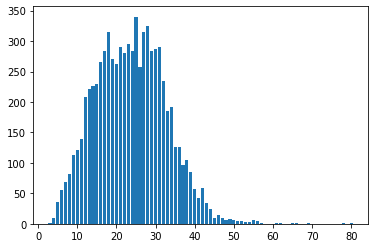

In [58]:
import matplotlib.pyplot as plt

unique = list(set(lens))
unique.sort()
cnt = [sum([1 if l==u else 0 for l in lens]) for u in unique]
plt.bar(unique, cnt)

Just in case there are some longer test sentences, I'll set the maximum length to 100.


In [10]:
# `encode_plus` will:
#   (1) Tokenize the sentence.
#   (2) Prepend the `[CLS]` token to the start.
#   (3) Append the `[SEP]` token to the end.
#   (4) Map tokens to their IDs.
#   (5) Pad or truncate the sentence to `max_length`
#   (6) Create attention masks for [PAD] tokens.

def encode(sentences, labels, tokenizer, max_len):
    encoded_dicts = [tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                     ) for sent in sentences]
    input_ids = [d['input_ids'] for d in encoded_dicts]  
    attention_masks = [d['attention_mask'] for d in encoded_dicts]  

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [11]:
input_ids, attention_masks, labels = encode(tweets, labels, tokenizer, max_len=100)
print('Original: ', tweets[0])
print('\nToken IDs:', input_ids[0])

Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Token IDs: tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
         2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [26]:
print(len(input_ids[0]))
tokenizer.convert_ids_to_tokens(input_ids[0][:20])

100


['[CLS]',
 'our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 '#',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## 3.5 Build Train & Validation DatatLoaders


In [14]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

def make_dataloader(input_ids, attention_masks, labels, split=1):  
    dataset = TensorDataset(input_ids, attention_masks, labels)

    if split:
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        print('{} training samples'.format(train_size))
        print('{} validation samples'.format(val_size))
    else: 
        train_dataset = dataset
        print(print('{} training samples (no validation)'.format(len(dataset))))

    # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
    batch_size = 32

    train_dataloader = DataLoader(
                          train_dataset,  # training samples.
                          sampler = RandomSampler(train_dataset), # Select batches randomly
                          batch_size = batch_size # Trains with this batch size.
                      )

    if split:
        # For validation the order doesn't matter, so just read them sequentially.
        validation_dataloader = DataLoader(
                                    val_dataset, # The validation samples.
                                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                                    batch_size = batch_size # Evaluate with this batch size.
                                )
    
        return train_dataloader, validation_dataloader

    return train_dataloader

In [38]:
train_dataloader, validation_dataloader = make_dataloader(input_ids, attention_masks, labels)

6851 training samples
762 validation samples


# 4. Train

## 4.1. Define Model: BertForSequenceClassification

In [ ]:
from transformers import BertForSequenceClassification, BertConfig

# Load BertForSequenceClassification (pretrained BERT model + a single linear classification layer on top) 
model = BertForSequenceClassification.from_pretrained(
              "bert-base-uncased",          # 12-layer BERT base model w/ uncased vocab
              num_labels = 2,               # number of output labels (2 for binary classification)  
              output_attentions = False,    # returns attentions weights?
              output_hidden_states = False, # return all hidden-states?
        )
model.cuda()

In [17]:
!nvidia-smi

Tue Jun 23 22:16:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |   1367MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [67]:
next(model.parameters()).is_cuda

True

## 4.2. Define Optimizer & Learning Rate Scheduler

For fine-tuning, the authors recommend choosing from following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, **32**  
- **Learning rate (Adam):** 5e-5, 3e-5, **2e-5**
- **Number of epochs:** **2**, 3, 4 

*The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

In [37]:
from transformers import AdamW 

# Note: AdamW is a class from the huggingface library (not pytorch)- 'W'= 'Weight Decay fix"
optimizer = AdamW(
                    model.parameters(),
                    lr = 5e-5,         # default 
                    eps = 1e-8         # default 
                )

## 4.3. Train

In [21]:
import numpy as np
import time, datetime

# Helper functions
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''Takes time in seconds and returns a string hh:mm:ss'''

    elapsed_rounded = int(round((elapsed)))  # Round to the nearest second
    return str(datetime.timedelta(seconds=elapsed_rounded))  # Format as hh:mm:ss

def set_random_seed(seed):
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [20]:
len(train_dataloader), len(validation_dataloader)

(215, 24)

In [35]:
import random
from transformers import get_linear_schedule_with_warmup

def train_BERT(train_dataloader, validation_dataloader, model, optimizer, n_epochs, output_hidden=0):   
    set_random_seed(seed=42)  # Set seed to make this reproducible.
    
    total_t0 = time.time()   # Measure the total training time for the whole run.
    training_stats = []   # Store training and valid loss, valid accuracy, and timings.
    hidden_states = []

    # lr scheduler
    n_batches_train = len(train_dataloader)
    scheduler = get_linear_schedule_with_warmup(  optimizer, 
                                                  num_warmup_steps = 0, # Default value in run_glue.py
                                                  num_training_steps = n_batches_train * n_epochs  )

    for epoch_i in range(n_epochs):   
        # =================== Training =================== #       
        t0 = time.time()   
        total_train_loss, total_train_accuracy = 0, 0
        model.train()

        for step, batch in enumerate(train_dataloader):
            input_ids, att_mask, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            model.zero_grad()        
            if output_hidden:
                loss, logits, h = model(input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=att_mask, 
                                        labels=labels)
                
                h = [layer.detach().cpu().numpy() for layer in h]
                if epoch_i == n_epochs - 1: # store the last epoch's hidden states
                    hidden_states.append(h[-1]) # only save last layer's h           
            else:
                loss, logits = model(input_ids, 
                                    token_type_ids=None, # Not required since training on a SINGLE sentence, not a pair
                                    attention_mask=att_mask, 
                                    labels=labels)
                
            total_train_loss += loss.item()  
            total_train_accuracy += flat_accuracy(logits.detach().cpu().numpy(), labels.detach().cpu().numpy())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()      
            scheduler.step()   # Update learning rate
        
        print("Epoch: {}/{}".format((epoch_i+1), n_epochs),
              "  Train loss: {0:.4f}".format(total_train_loss/n_batches_train),
              "  Train Acc: {0:.4f}".format(total_train_accuracy/n_batches_train),
              "  ({:})".format(format_time(time.time() - t0)))
        
        training_stats.append( {'epoch':           epoch_i + 1,
                                'Training Loss':   total_train_loss/n_batches_train,
                                'Training Acc' :   total_train_accuracy/n_batches_train,
                                'Training Time':   format_time(time.time() - t0)} )

        if validation_dataloader is not None:
            # =================== Validation =================== #
            n_batches_valid = len(validation_dataloader)
            t0 = time.time()
            model.eval()

            total_eval_accuracy, total_eval_loss = 0, 0
            for batch in validation_dataloader:
                v_input_ids, v_att_mask, v_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
                with torch.no_grad(): 
                    if output_hidden:       
                        loss, logits, val_h = model(v_input_ids, 
                                                    token_type_ids=None, 
                                                    attention_mask=v_att_mask,
                                                    labels=v_labels)
                    
                        val_h = [layer.detach().cpu().numpy() for layer in val_h] # save GPU memory
                    else:
                        loss, logits = model(v_input_ids, 
                                             token_type_ids=None, 
                                             attention_mask=v_att_mask,
                                             labels=v_labels)
                total_eval_loss += loss.item()
                logits = logits.detach().cpu().numpy()
                label_ids = v_labels.detach().cpu().numpy()
                total_eval_accuracy += flat_accuracy(logits, label_ids)

            print("  Valid Loss: {0:.4f}".format(total_eval_loss/n_batches_valid),
                  "  Valid Acc: {0:.4f}".format(total_eval_accuracy/n_batches_valid),
                  "  ({:})".format(format_time(time.time()-t0)))

            training_stats.append( {'            Valid. Loss':     total_eval_loss/n_batches_valid,
                                    'Valid. Acc':   total_eval_accuracy/n_batches_valid,
                                    'Validation Time': format_time(time.time()-t0)} )

    print("\nTraining complete.")
    print("Duration: {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    if output_hidden:
        return training_stats, hidden_states
    else:
        return training_stats

In [39]:
training_stats = train_BERT(train_dataloader, validation_dataloader, 
                            model=model, optimizer=optimizer, 
                            n_epochs=2)

Epoch: 1/2   Train loss: 0.4424   Train Acc: 0.8048   (0:01:59)
  Valid Loss: 0.4162   Valid Acc: 0.8301   (0:00:05)
Epoch: 2/2   Train loss: 0.2911   Train Acc: 0.8865   (0:01:59)
  Valid Loss: 0.4472   Valid Acc: 0.8223   (0:00:05)

Training complete.
Duration: 0:04:08 (h:mm:ss)


## 4.4 Train again w/ ENTIRE data (no validation)

Now that we observed that 2 epochs are enough in order to prevent overfitting, let's train w/ the entire dataset.

In [40]:
train_dataloader = make_dataloader(input_ids, attention_masks, labels, split=0)

7613 training samples (no validation)
None


In [ ]:
model = BertForSequenceClassification.from_pretrained(
              "bert-base-uncased",          # 12-layer BERT base model, w/ uncased vocab
              num_labels = 2,               # number of output labels (2 for binary classification)  
              output_attentions = False,    # Whether the model returns attentions weights.
              output_hidden_states = False, # Whether the model returns all hidden-states.
        )
model.cuda()

In [42]:
optimizer = AdamW(  model.parameters(), lr = 5e-5, eps = 1e-8)

In [43]:
training_stats = train_BERT(train_dataloader, None,
                            model=model, optimizer=optimizer, 
                            n_epochs=2)

Epoch: 1/2   Train loss: 0.4403   Train Acc: 0.8029   (0:02:14)
Epoch: 2/2   Train loss: 0.2898   Train Acc: 0.8889   (0:02:12)

Training complete.
Duration: 0:04:26 (h:mm:ss)


# 5 Predict & Submit

## 5.1 Test Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [46]:
test_df = pd.read_csv("test.csv")
test_sentences = test_df.text.values
test_sentences = [" ".join([word if 'http://' not in word else "http" for word in t.split()]) for t in test_sentences]
test_sentences = [" ".join([word for word in t.split() if '@' not in word]) for t in test_sentences]
test_encoded_sentences = [tokenizer.encode(s) for s in test_sentences]
test_sent_lens = np.array([len(s) for s in test_encoded_sentences])

print('# of sentences:', len(test_sentences))
print('Max sentence length: ', max(test_sent_lens))
print('Avg sentence length: ', np.mean(test_sent_lens))
print('Median sentence length: ', np.median(test_sent_lens))

# of sentences: 3263
Max sentence length:  73
Avg sentence length:  23.593931964449894
Median sentence length:  23.0


In [47]:
encoded_dicts = [tokenizer.encode_plus(  sent,                      
                                         add_special_tokens = True, 
                                         max_length = 100,          
                                         pad_to_max_length = True,
                                         return_attention_mask = True,   
                                         return_tensors = 'pt'  ) for sent in test_sentences]
input_ids = [d['input_ids'] for d in encoded_dicts]  
input_ids = torch.cat(input_ids, dim=0)
attention_masks = [d['attention_mask'] for d in encoded_dicts]  
attention_masks = torch.cat(attention_masks, dim=0)

prediction_data = TensorDataset(input_ids, attention_masks)
prediction_dataloader = DataLoader(dataset = prediction_data, 
                                   sampler = SequentialSampler(prediction_data), # doesn't need to be sampled randomly
                                   batch_size = 32)

## 5.2 Predict Test Set


In [48]:
len(prediction_dataloader)

102

In [49]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
model.eval()
predictions, true_labels = [], []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    with torch.no_grad():
        logits = model(  b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask  ) # no loss, since "labels" not provided

    logits = logits[0].detach().cpu().numpy() # extract x from [[x]]
    predictions.append(logits)
print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [50]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

## 5.3 Make Submission File

In [51]:
submission = pd.DataFrame(test_df.id)
submission['target'] = flat_predictions
submission.to_csv('submission_6_23_17_10.csv', index=False)